In [1]:
from backtest import do_simulation, daily_potential_pnl
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [2]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

## Some full simulations

100%|██████████| 231/231 [04:44<00:00,  1.23s/it]

Skipped 1 days due to incomplete data.


<Axes: xlabel='timestamp'>

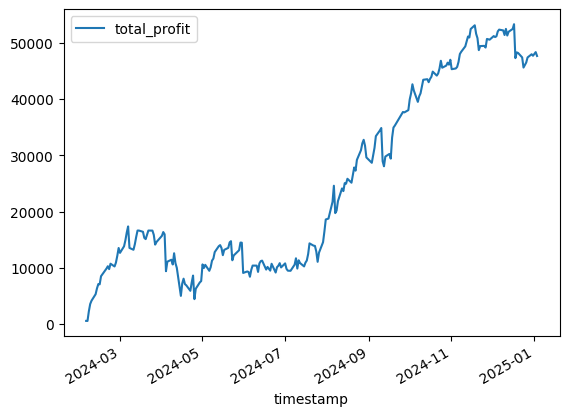

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 6),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(60),
    closing_strategy_last_n(30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

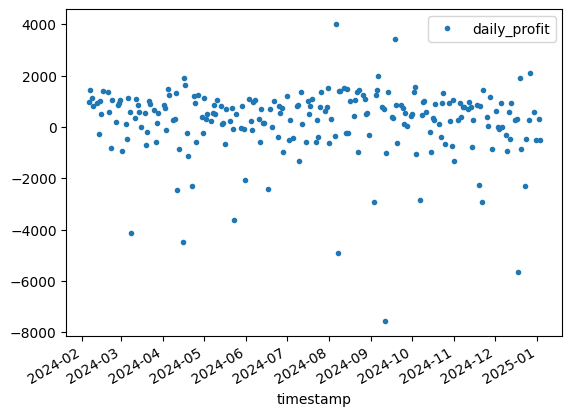

In [14]:
diff_df = profit_df.diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

Then a stop loss of around $2k sound like a good idea maybe?

100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Skipped 2 days due to incomplete data.


<Axes: xlabel='timestamp'>

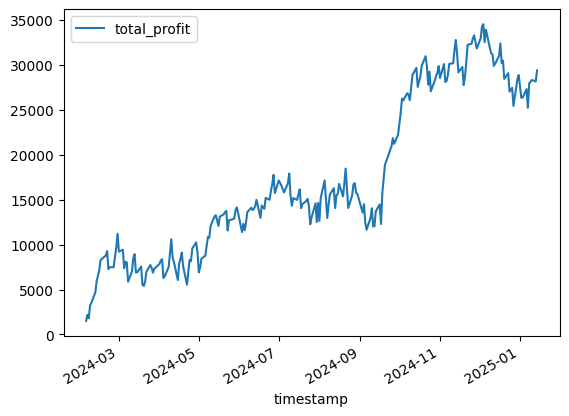

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
    closing_strategy_stoploss_or_last_n(2000, 30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

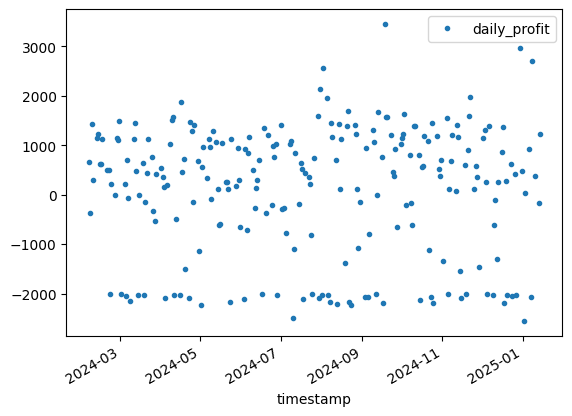

In [7]:
diff_df = profit_df.dropna().diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

In [8]:
f"Winning rate: {diff_df[diff_df['daily_profit'] > 0].shape[0] / diff_df.shape[0]:.2%}"

'Winning rate: 63.71%'

## Some potential P&L analysis based on daily position movement

In [3]:
# 1. either fetch anew:

# daily_movements = daily_potential_pnl(
#     datetime(2024, 2, 5),
#     datetime(2025, 1, 15),
#     asset,
#     asset_data_service,
#     options_data_service,
#     opening_strategy_iron_condor_specific_minute_idx(2),
# )


# 2. or load from file:

import json

with open("daily_movements_open2.json", "r") as f:
    daily_movements = json.load(f)
    daily_movements = [np.array(l) for l in daily_movements]

In [4]:
daily_movements = [movement for movement in daily_movements if np.isnan(movement).all() == False]
len(daily_movements)

235

In [5]:
import matplotlib.pyplot as plt

In [6]:
EXLUDE_LAST_N = 30  # don't close positions in the last half hour

In [7]:
WAIT_FOR_N_BEFORE_STOPLOSS = 150  # 2.5 hours

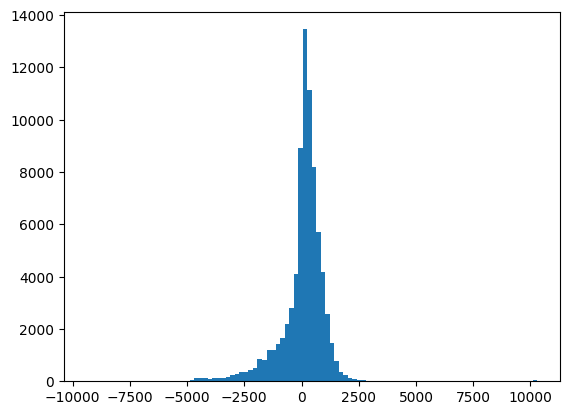

In [8]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

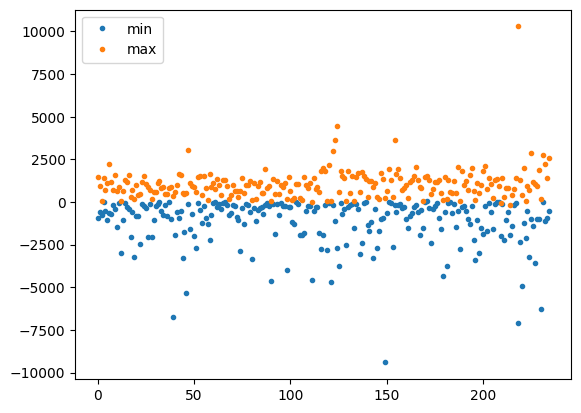

In [9]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [10]:
n_days = daily_min_max_df.shape[0]

In [11]:
profit_categories = [np.inf, 2000, 1750, 1600, 1500, 1250, 1200, 1000, 800, 750, 500, 400, 300, 250]
loss_categories = [-250, -300, -400, -500, -750, -800, -1000, -1200, -1250, -1500, -1600, -1750, -2000, -2500, -3000, -4000, -5000, -np.inf]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({inf: 0.0,
  2000: 0.06382978723404255,
  1750: 0.11914893617021277,
  1600: 0.14893617021276595,
  1500: 0.19574468085106383,
  1250: 0.33617021276595743,
  1200: 0.3617021276595745,
  1000: 0.48936170212765956,
  800: 0.6170212765957447,
  750: 0.625531914893617,
  500: 0.7702127659574468,
  400: 0.825531914893617,
  300: 0.851063829787234,
  250: 0.8680851063829788},
 {-250: 0.7191489361702128,
  -300: 0.676595744680851,
  -400: 0.625531914893617,
  -500: 0.5872340425531914,
  -750: 0.46808510638297873,
  -800: 0.451063829787234,
  -1000: 0.3872340425531915,
  -1200: 0.3276595744680851,
  -1250: 0.3191489361702128,
  -1500: 0.28085106382978725,
  -1600: 0.2553191489361702,
  -1750: 0.23829787234042554,
  -2000: 0.18723404255319148,
  -2500: 0.13617021276595745,
  -3000: 0.09361702127659574,
  -4000: 0.0425531914893617,
  -5000: 0.02127659574468085,
  -inf: 0.0})

In [12]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 \
                    if closing_strategy_limit_or_stoploss_after_n_or_last_m(
                        profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N
                    )(daily_movement) > 0 \
                    else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0
-250.0,0.417021,0.417021,0.417021,0.417021,0.417021,0.442553,0.451064,0.476596,0.553191,0.561702,0.680851,0.740426,0.787234,0.804255
-300.0,0.434043,0.434043,0.434043,0.434043,0.434043,0.459574,0.468085,0.489362,0.565957,0.574468,0.689362,0.740426,0.787234,0.804255
-400.0,0.451064,0.451064,0.451064,0.451064,0.451064,0.476596,0.485106,0.506383,0.578723,0.587234,0.702128,0.744681,0.787234,0.804255
-500.0,0.472340,0.472340,0.472340,0.472340,0.472340,0.489362,0.497872,0.514894,0.591489,0.595745,0.710638,0.748936,0.791489,0.808511
-750.0,0.544681,0.548936,0.548936,0.548936,0.548936,0.561702,0.570213,0.582979,0.642553,0.646809,0.731915,0.774468,0.808511,0.821277
-800.0,0.544681,0.548936,0.548936,0.548936,0.548936,0.561702,0.570213,0.582979,0.642553,0.646809,0.731915,0.774468,0.808511,0.821277
-1000.0,0.574468,0.578723,0.578723,0.578723,0.578723,0.591489,0.600000,0.608511,0.659574,0.663830,0.744681,0.791489,0.821277,0.834043
-1200.0,0.595745,0.600000,0.600000,0.600000,0.600000,0.617021,0.625532,0.634043,0.676596,0.680851,0.753191,0.800000,0.825532,0.838298
-1250.0,0.600000,0.604255,0.604255,0.604255,0.604255,0.621277,0.629787,0.638298,0.680851,0.685106,0.757447,0.804255,0.829787,0.842553
-1500.0,0.625532,0.629787,0.629787,0.629787,0.629787,0.646809,0.655319,0.663830,0.706383,0.706383,0.770213,0.817021,0.842553,0.855319


<Axes: title={'center': 'Win rates for strat waiting for 150 minutes before stoploss'}>

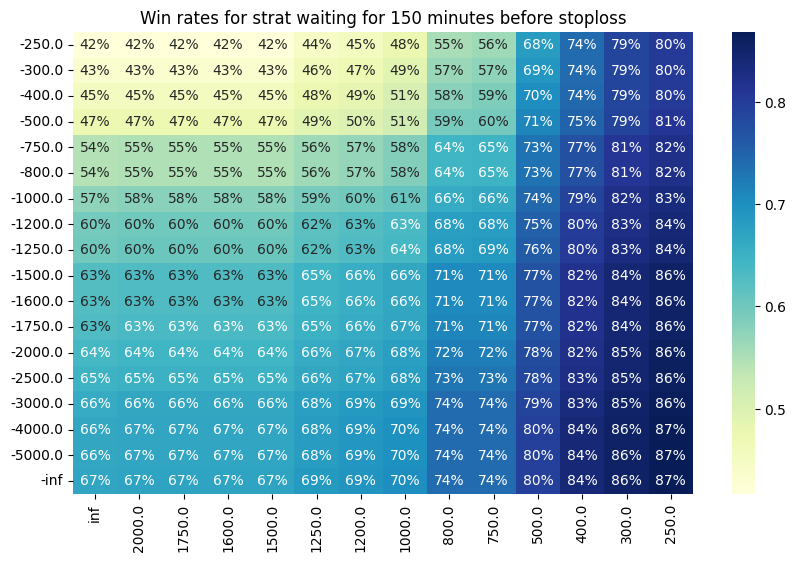

In [13]:
import seaborn as sns

# win rates

plt.figure(figsize=(10, 6))
plt.title(f"Win rates for strat waiting for {WAIT_FOR_N_BEFORE_STOPLOSS} minutes before stoploss")
sns.heatmap(profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

In [14]:
# profitable win rates according to Kelly criterion

kelly_profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            1 - abs(profit_cat / (profit_cat - loss_cat)) if not np.isinf(profit_cat) and not np.isinf(loss_cat) else np.nan
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

kelly_profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0
-250.0,NaN,0.111111,0.125000,0.135135,0.142857,0.166667,0.172414,0.200000,0.238095,0.250000,0.333333,0.384615,0.454545,0.500000
-300.0,NaN,0.130435,0.146341,0.157895,0.166667,0.193548,0.200000,0.230769,0.272727,0.285714,0.375000,0.428571,0.500000,0.545455
-400.0,NaN,0.166667,0.186047,0.200000,0.210526,0.242424,0.250000,0.285714,0.333333,0.347826,0.444444,0.500000,0.571429,0.615385
-500.0,NaN,0.200000,0.222222,0.238095,0.250000,0.285714,0.294118,0.333333,0.384615,0.400000,0.500000,0.555556,0.625000,0.666667
-750.0,NaN,0.272727,0.300000,0.319149,0.333333,0.375000,0.384615,0.428571,0.483871,0.500000,0.600000,0.652174,0.714286,0.750000
-800.0,NaN,0.285714,0.313725,0.333333,0.347826,0.390244,0.400000,0.444444,0.500000,0.516129,0.615385,0.666667,0.727273,0.761905
-1000.0,NaN,0.333333,0.363636,0.384615,0.400000,0.444444,0.454545,0.500000,0.555556,0.571429,0.666667,0.714286,0.769231,0.800000
-1200.0,NaN,0.375000,0.406780,0.428571,0.444444,0.489796,0.500000,0.545455,0.600000,0.615385,0.705882,0.750000,0.800000,0.827586
-1250.0,NaN,0.384615,0.416667,0.438596,0.454545,0.500000,0.510204,0.555556,0.609756,0.625000,0.714286,0.757576,0.806452,0.833333
-1500.0,NaN,0.428571,0.461538,0.483871,0.500000,0.545455,0.555556,0.600000,0.652174,0.666667,0.750000,0.789474,0.833333,0.857143


<Axes: title={'center': 'Difference between win rates and Kelly criterion threshold'}>

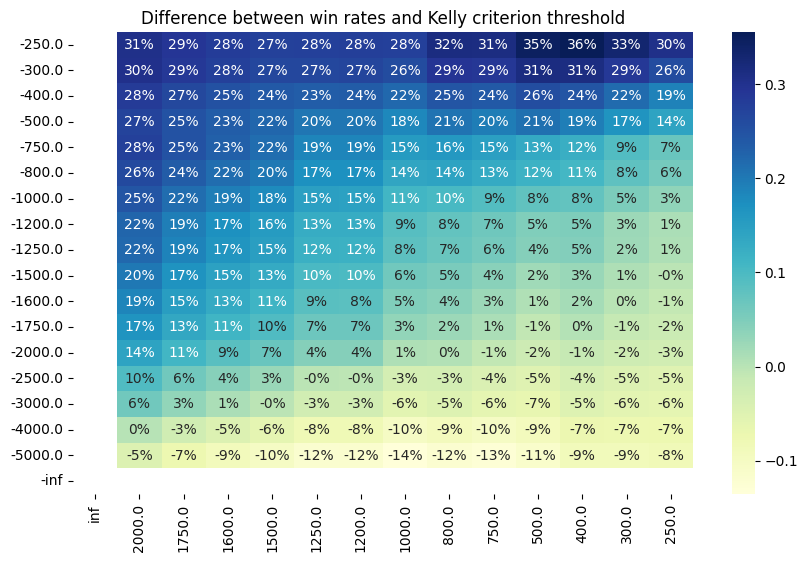

In [15]:
# difference between win rates and Kelly criterion

diff_profit_loss_matrix = profit_loss_matrix - kelly_profit_loss_matrix

plt.figure(figsize=(10, 6))
plt.title("Difference between win rates and Kelly criterion threshold")
sns.heatmap(diff_profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Not reaching limit or stoploss'}>

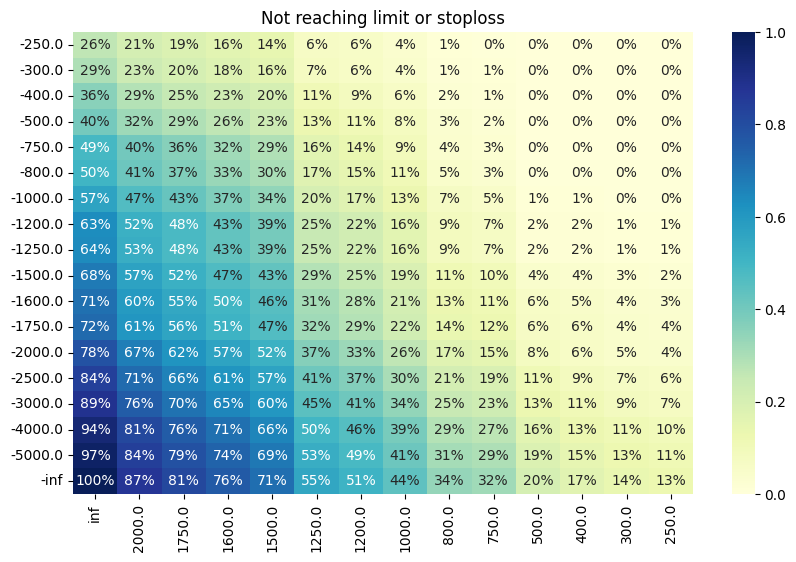

In [16]:
not_reaching_limit_or_stoploss_df = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if ((daily_movement >= loss_cat).all() & (daily_movement <= profit_cat).all()) else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(10, 6))
plt.title("Not reaching limit or stoploss")
sns.heatmap(not_reaching_limit_or_stoploss_df, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Total profit ($)'}>

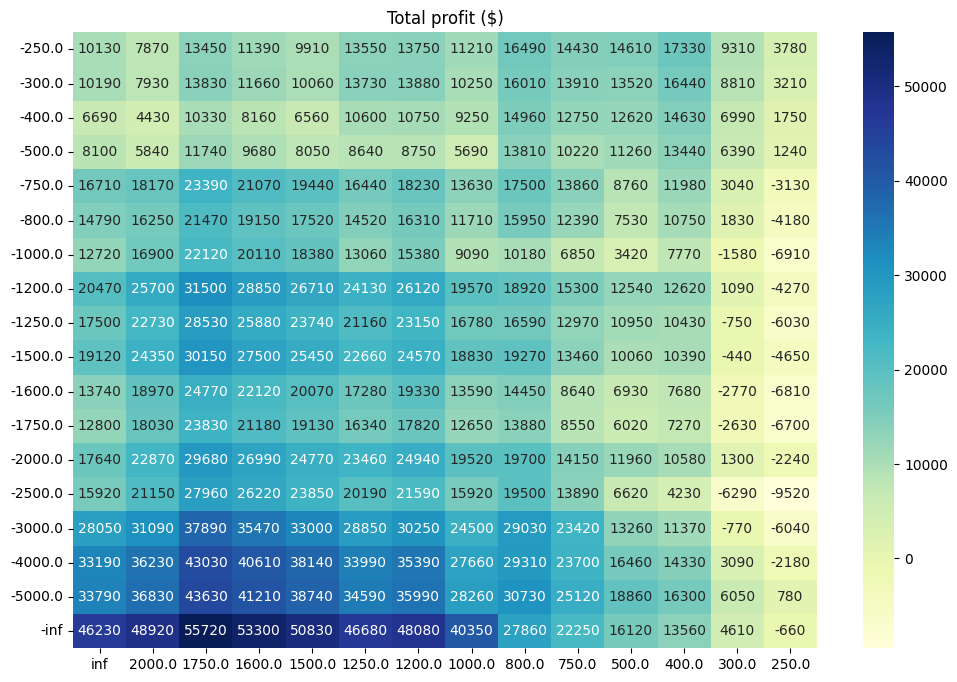

In [37]:
# total profit

total_profit_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 100, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Total profit ($)")
sns.heatmap(total_profit_matrix, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Cumulative profit for strategy: 1750 limit w/o stop loss'}>

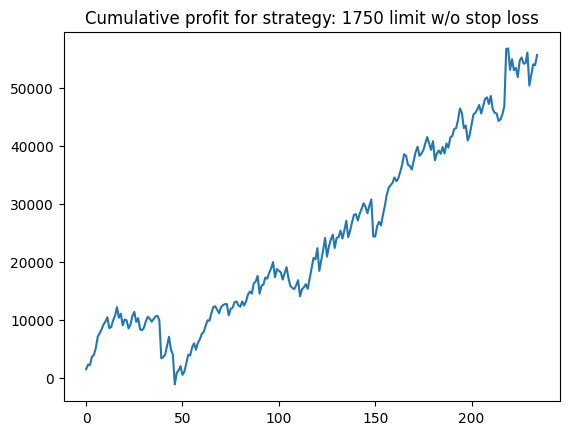

In [75]:
plt.title("Cumulative profit for strategy: 1750 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 400 limit w/ -400 stop loss'}>

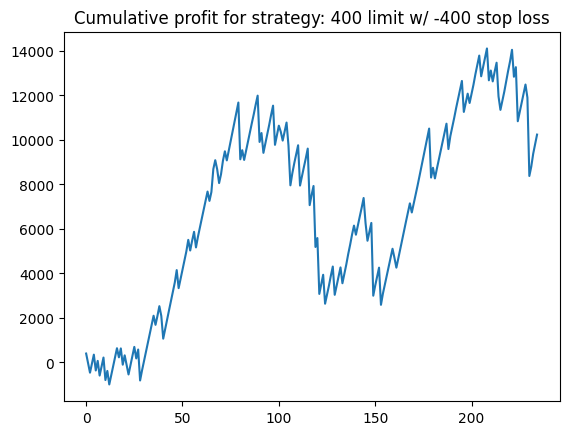

In [76]:
plt.title("Cumulative profit for strategy: 400 limit w/ -400 stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Biggest losing days ($)'}>

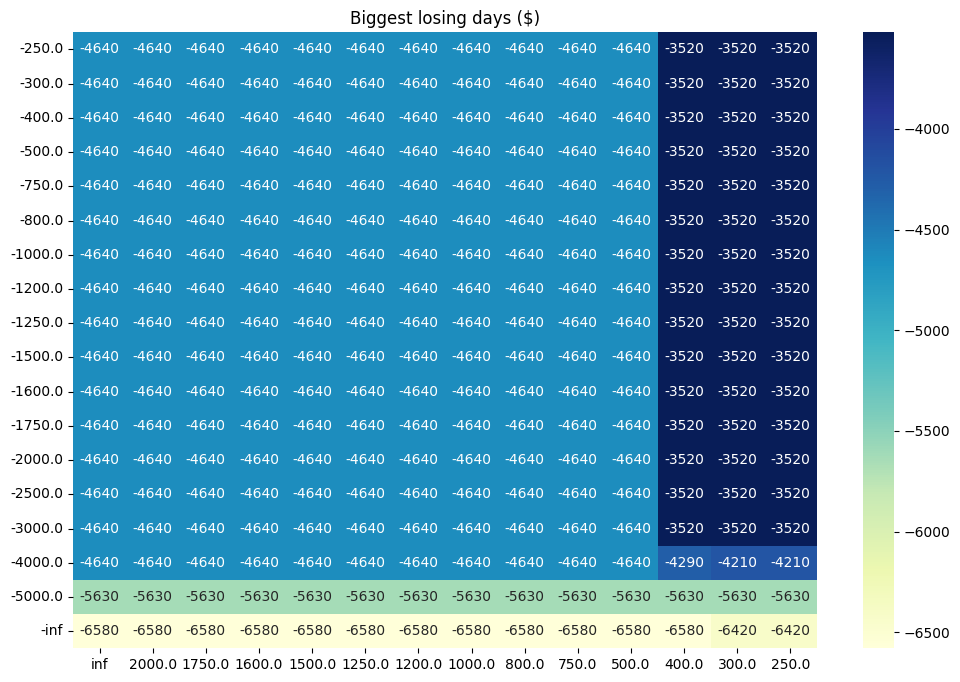

In [42]:
# biggest losing days

top_losers_df = pd.DataFrame(
    {
        profit_cat: [
            min(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Biggest losing days ($)")
sns.heatmap(top_losers_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Worst Day'}>

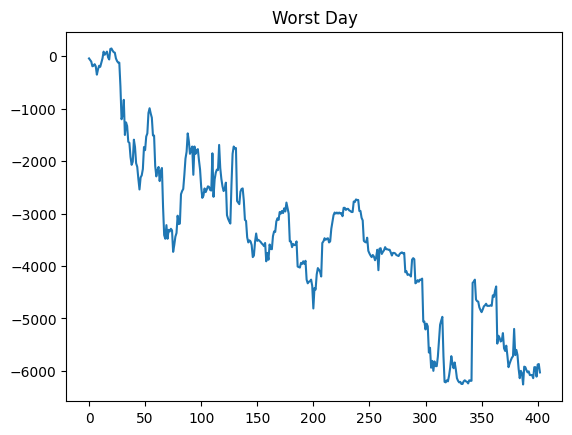

In [52]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title("Worst Day")
sns.lineplot(daily_movements[np.argmin(daily_pnl)])

<Axes: title={'center': 'Worst Day'}>

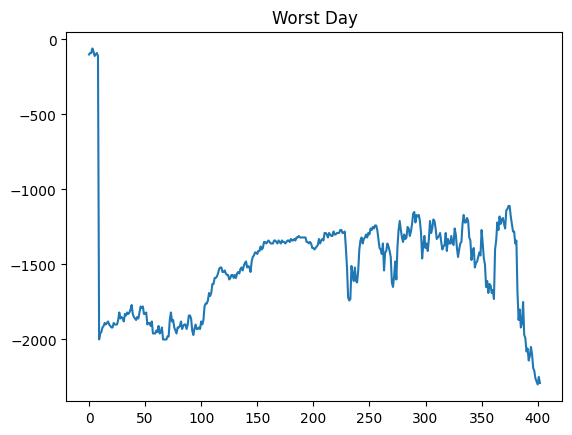

In [53]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, 0, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title("Worst Day")
sns.lineplot(daily_movements[np.argmin(daily_pnl)])

In [68]:

# longest negative streak

def count_losing_streak_subarray(arr):
    curr_idx = 0
    total_loss = 0
    while curr_idx < len(arr) and arr[curr_idx] < 0:
        total_loss += arr[curr_idx]
        curr_idx += 1
    return curr_idx, total_loss 


def longest_losing_streak_loss(arr):
    _, longest_negative_streak_money = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_money


def longest_losing_streak_days(arr):
    longest_negative_streak_days, _ = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_days

def max_losing_streak(arr):
    return min(
        count_losing_streak_subarray(arr[i:])[1]
        for i in range(len(arr))
    )


longest_losing_streak_days(daily_pnl), longest_losing_streak_loss(daily_pnl), max_losing_streak(daily_pnl)

(4, -1899.9999999999998, -2340.0)

<Axes: title={'center': "Longest losing streak (days) (don't wait until applying stoploss)"}>

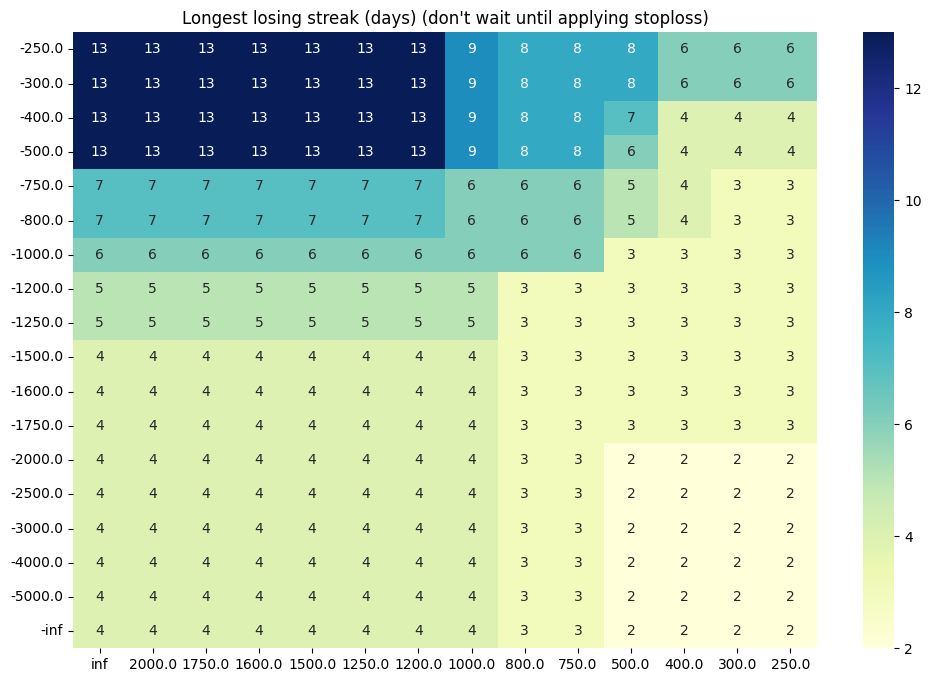

In [63]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak (days) (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Longest losing streak ($)  (don't wait until applying stoploss)"}>

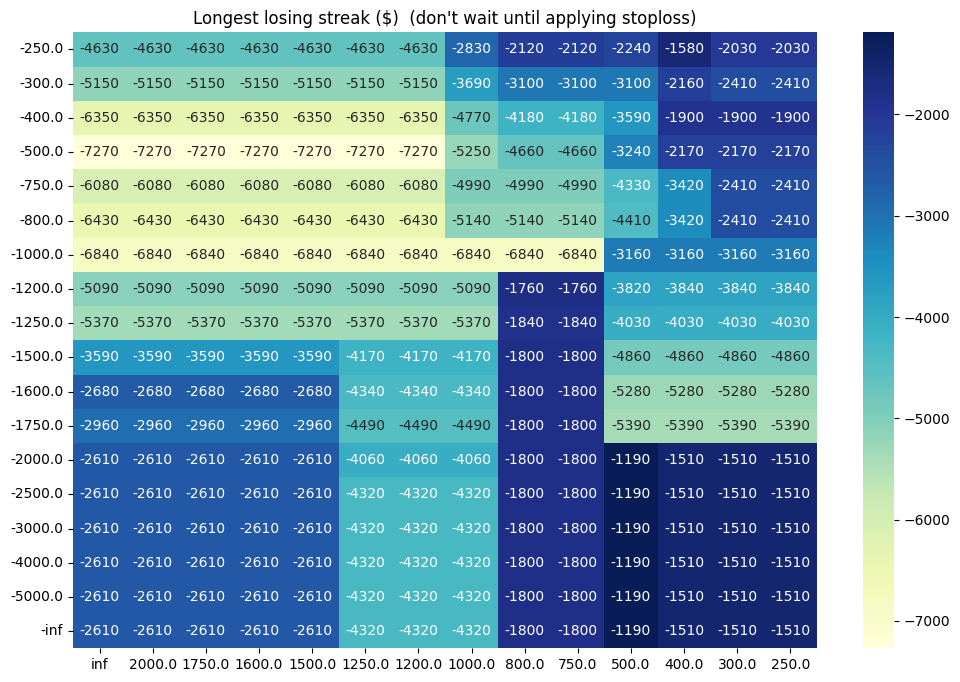

In [64]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Worst losing streak ($)  (don't wait until applying stoploss)"}>

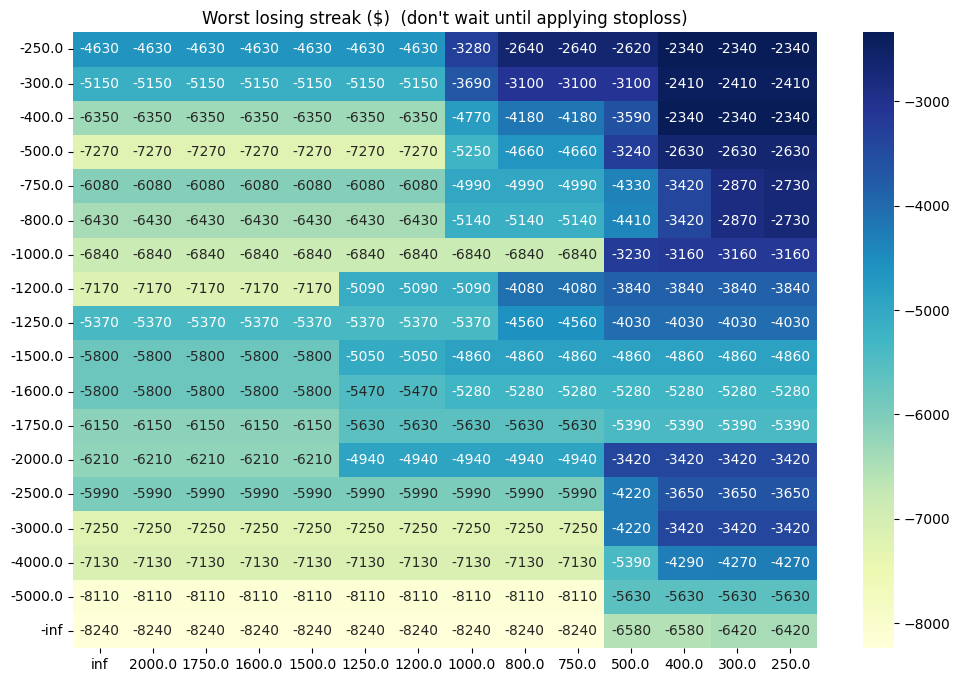

In [71]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Worst losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Longest losing streak (days) (don't wait until applying stoploss)"}>

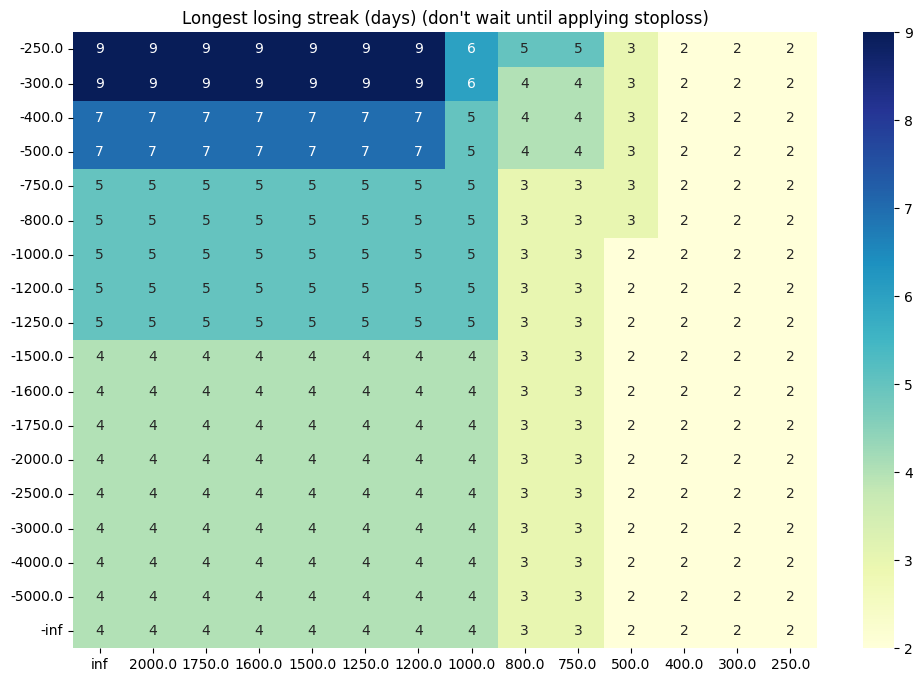

In [65]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak (days) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak ($) (wait for 150min before applying stoploss)'}>

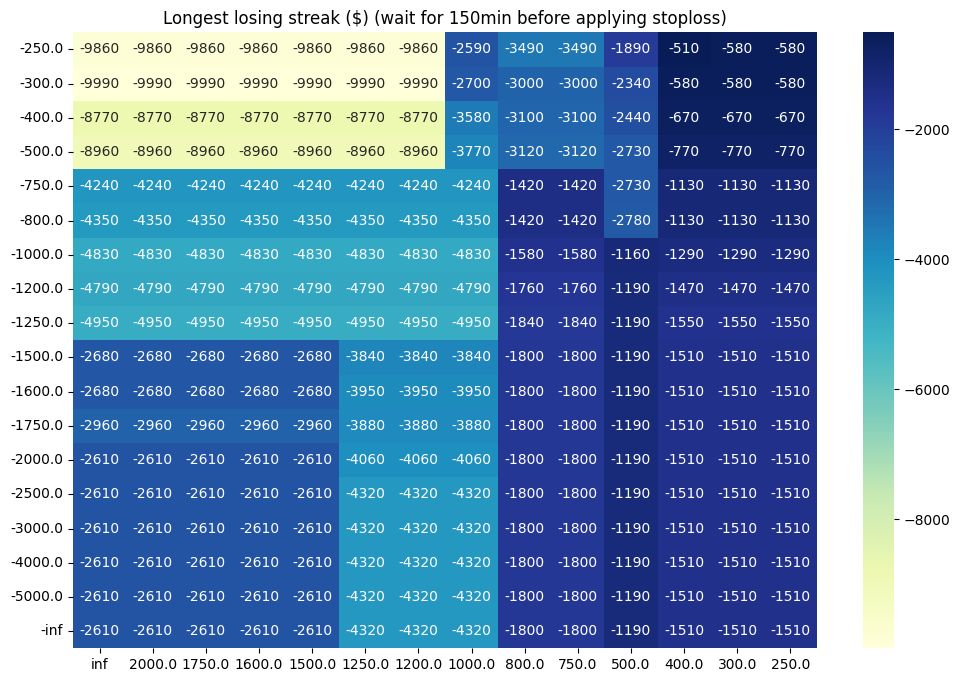

In [66]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Worst losing streak ($) (wait for 150min before applying stoploss)'}>

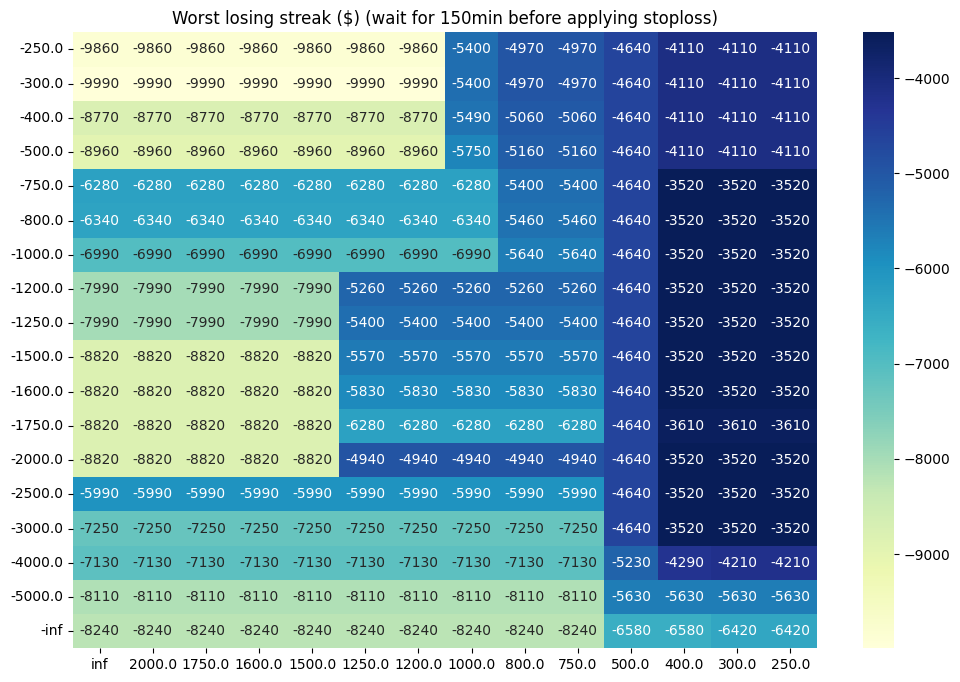

In [72]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Worst losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")